In [2]:
import os
from torch.utils.data import DataLoader
from dataloader_e2e import create_dataset_12
import matplotlib.pyplot as plt
from PIL import ImageOps
import torchvision
import numpy as np
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import *

path = os.getcwd()
path = '/root/notebooks/sample/dataset/ECG100_224/'
train_dataloader,test_dataloader,label_lead, labels=create_dataset_12(path,1,None)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)


Classification lab : {'Lateral': 0, 'Posterior': 1, 'Anterior': 2, 'Inferior': 3, 'Normal': 4}
Number of datas 378
torch.Size([12, 378, 3, 112, 224])
378
378
cuda:1


In [27]:
# モデルクラス
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 畳み込み層や全結合層などを定義する
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.faltten = nn.Flatten()
        self.fc1 = nn.Linear(16,16)
        self.fc2 = nn.Linear(16, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = self.faltten(x)
        #x = x.view(-1, 16 * 56 * 112)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# モデルのインスタンスを作成
model = CNNModel().to(device)


# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=0.0001)
bestscore = 1000.0
loss_list,loss_list_test = [], []
f1s, f1s_test = [],[]
acc, acc_test = [], []

num_epochs = 5000

In [28]:
# モデル訓練　事前学習12クラス分類
for epoch in range(num_epochs):
    model.train()
    running_loss, running_loss_test = 0.0, 0.0
    preds, label =[], []
    preds_test,label_test = [], []

    for ecg_image,labels,label_lead,patients,num_leads in train_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        
        label_lead = label_lead.reshape(-1).to(device)
        optimizer.zero_grad()  # 勾配を初期化
        
        outputs = model(image)  # モデルの出力を計算

        prob, pred=torch.max(outputs,1)
        preds.extend(pred.tolist())
        label.extend(label_lead.tolist())
        loss = criterion(outputs, label_lead)  # 損失を計算
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss += loss.item()


    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        label_lead = label_lead.reshape(-1).to(device)

        outputs = model(image)  # モデルの出力を計算
        prob, pred=torch.max(outputs,1)
        preds_test.extend(pred.tolist())
        label_test.extend(label_lead.tolist())
        
        loss = criterion(outputs, label_lead)  # 損失を計算

        running_loss_test += loss.item()
    
    score = running_loss_test/len(test_dataloader)
    if score < bestscore:
        bestscore = score
        torch.save(model.state_dict(), '/root/notebooks/sample/models/bestmodel.pth')
        print('best score!!')
    loss_list.append(running_loss/len(train_dataloader))
    loss_list_test.append(running_loss_test/len(test_dataloader))
    f1 = f1_score(preds,label,average='macro')
    f1_test = f1_score(preds_test,label_test,average='macro')
    f1s.append(f1)
    f1s_test.append(f1_test)
    accuracy = accuracy_score(preds,label)
    accuracy_test = accuracy_score(preds_test,label_test)
    acc.append(accuracy)
    acc_test.append(accuracy_test)

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs}] Train-Loss: {running_loss/len(train_dataloader)} Test-Loss: {running_loss_test/len(train_dataloader)} Train-f1: {f1} Test-f1: {f1_test} Train-acc: {accuracy} Test-acc: {accuracy_test}")


best score!!
Epoch [1/5000] Train-Loss: 2.4901304623938554 Test-Loss: 0.6253765166200549 Train-f1: 0.012820512820512822 Test-f1: 0.012820512820512822 Train-acc: 0.08333333333333333 Test-acc: 0.08333333333333333
best score!!
Epoch [2/5000] Train-Loss: 2.468754612057414 Test-Loss: 0.6154095550246587 Train-f1: 0.043901894548938 Test-f1: 0.049805723507777205 Train-acc: 0.09519867549668874 Test-acc: 0.14364035087719298
best score!!
Epoch [3/5000] Train-Loss: 2.392530288127874 Test-Loss: 0.594052855542164 Train-f1: 0.04869039157374028 Test-f1: 0.05456128070944911 Train-acc: 0.14873068432671083 Test-acc: 0.14364035087719298
best score!!
Epoch [4/5000] Train-Loss: 2.312711785960671 Test-Loss: 0.5799106462112326 Train-f1: 0.07244782232846154 Test-f1: 0.08806117814384525 Train-acc: 0.1586644591611479 Test-acc: 0.1611842105263158
best score!!
Epoch [5/5000] Train-Loss: 2.2681630747207744 Test-Loss: 0.5732782996253462 Train-f1: 0.11044049816961753 Test-f1: 0.10886687452871614 Train-acc: 0.16997792

In [29]:
# モデル評価
pred,label = [],[]
model.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel.pth'))
model.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    label_lead = label_lead.reshape(-1).to(device)
    label.extend(label_lead.tolist())
    outputs = model(image)  # モデルの出力を計算
    prob, preds=torch.max(outputs,1)
    pred.extend(preds.tolist())
    f1_test = f1_score(preds.tolist(),label_lead.tolist(),average='macro')
    
    loss = criterion(outputs, label_lead)  # 損失を計算

    running_loss_test += loss.item()


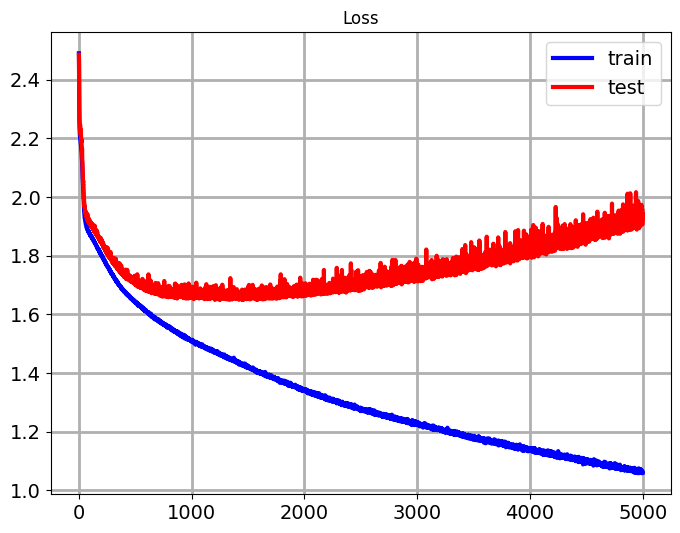

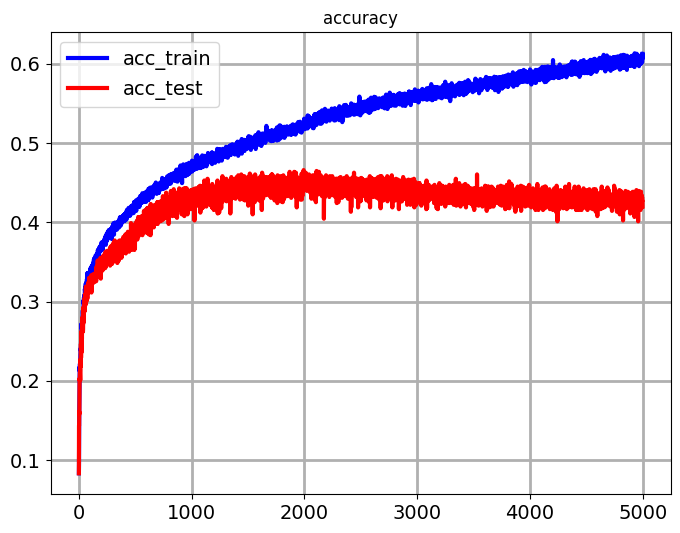

In [30]:
# 学習曲線 (損失関数) 事前学習
plt.figure(figsize=(8,6))
plt.plot(loss_list,label='train', lw=3, c='b')
plt.plot(loss_list_test,label='test', lw=3, c='r')
plt.title('Loss')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (精度)
plt.figure(figsize=(8,6))
plt.plot(acc,label='acc_train', lw=3, c='b')
plt.plot(acc_test,label='acc_test', lw=3, c='r')
plt.title('accuracy')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

Confusion matrix, without normalization
[[39  8  2  1 16  3  0  0  0  1  2  4]
 [14 41  1  2  1  8  0  0  1  1  3  4]
 [ 0 12 27  8  9  7  2  0  3  2  2  4]
 [ 0  0  1 68  2  0  4  0  1  0  0  0]
 [14  0  8  1 41  1  5  0  2  1  0  3]
 [ 7 18  9  3  3 24  1  0  3  1  0  7]
 [ 5  2  2  3  7  3 43  9  0  2  0  0]
 [ 0  6  3  0  0  2 12 29 18  3  2  1]
 [ 1  2  3  0  3  1  6 18 20 21  0  1]
 [ 0  1  2  8  3  0  3  4 14 24 14  3]
 [ 8  4  0  0  8  0  1  1  1 20 21 12]
 [13  7  2  0  4  6  0  0  0  6 10 28]]


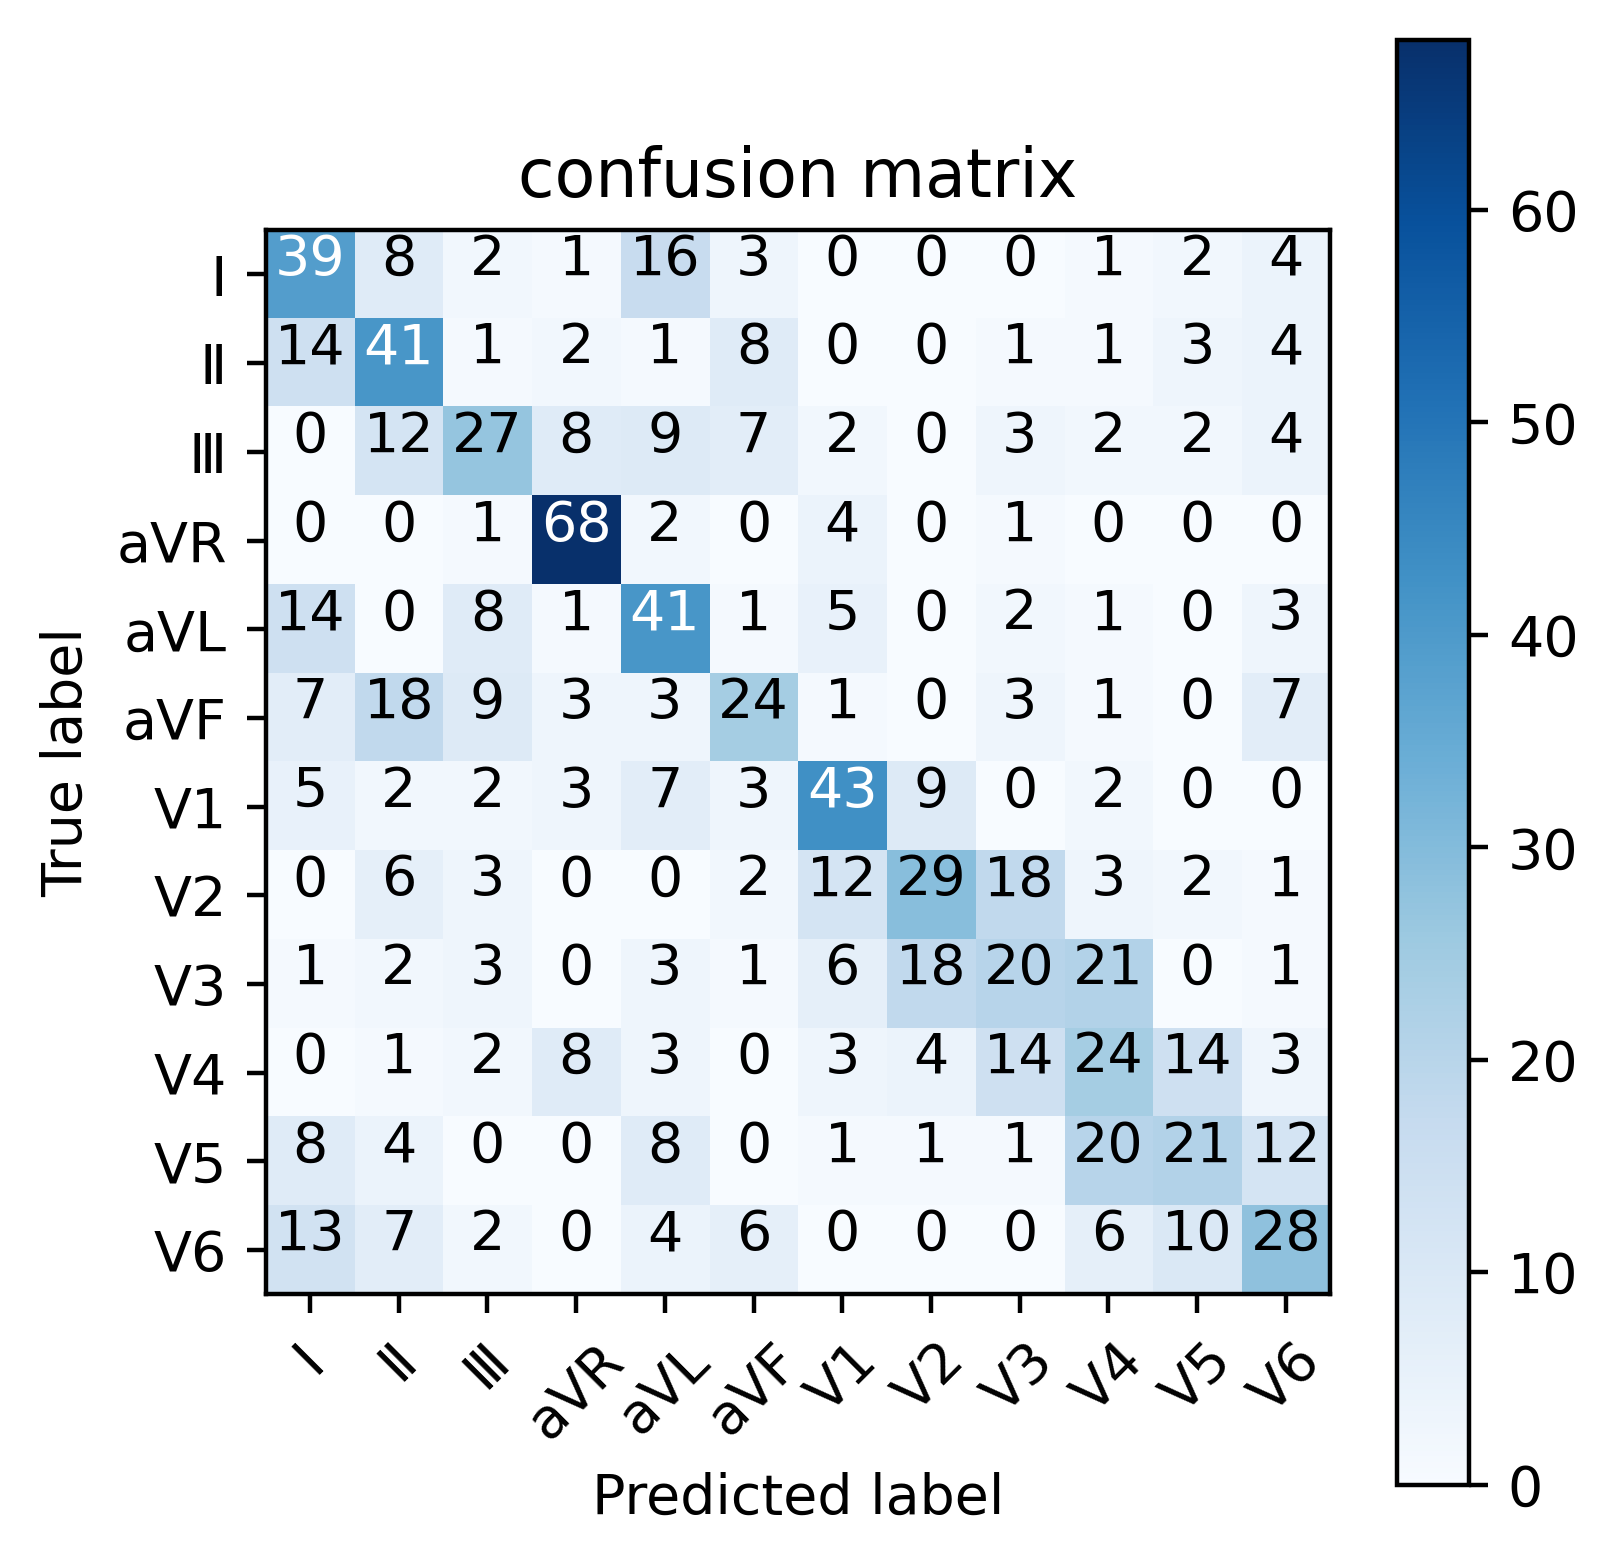

In [31]:
# Confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
           """
           This function prints and plots the confusion matrix.
           Normalization can be applied by setting `normalize=True`.
           """
           if normalize:
               cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
               print("Normalized confusion matrix")
           else:
               print('Confusion matrix, without normalization')
           print(cm)
           plt.imshow(cm, interpolation='nearest', cmap=cmap)
           plt.title(title)
           plt.colorbar()
           tick_marks = np.arange(len(classes))
           plt.xticks(tick_marks, classes, rotation=45)
           plt.yticks(tick_marks, classes)
           fmt = '.2f' if normalize else 'd'
           thresh = cm.max() / 2.
           for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
               plt.text(j, i, format(cm[i, j], fmt),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
           plt.tight_layout()
           plt.ylabel('True label')
           plt.xlabel('Predicted label')
           #plt.savefig(output_file)


labels=[0,1,2,3,4,5,6,7,8,9,10,11]
label2=['Ⅰ','Ⅱ','Ⅲ','aVR','aVL','aVF','V1', 'V2', 'V3', 'V4', 'V5','V6']
cnf_matrix=confusion_matrix(label,pred,labels=labels)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2,title=title)
plt.show()

In [37]:
# CNNモデルの特徴抽出器を取り出す
feature_extractor = nn.Sequential(*list(model.children())[:-2])

# 新しい全結合層を追加
feature_extractor.to(device)
print(feature_extractor)


# カスタムレイヤーを定義
class MeanLayer(nn.Module):
    def forward(self, x):
        return torch.mean(x, dim=0, keepdim=True)

# nn.Sequential内にカスタムレイヤーを含むモデルを定義
CNN_diagnosis = nn.Sequential(
    feature_extractor,
    nn.Linear(16, 16),
    nn.Linear(16, 5),
    MeanLayer()  # カスタムレイヤーを追加
)

CNN_diagnosis.to(device)

print(CNN_diagnosis)



Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Flatten(start_dim=1, end_dim=-1)
)
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Linear(in_features=16, out_features=16, bias=True)
  (2): Linear(in_features=16, out_features=5, bias=True)
  (3): MeanLayer()
)


In [38]:
## 診断モデル

# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(CNN_diagnosis.parameters(), lr=0.00001)
bestscore_dx = 1000.0
loss_list_dx,loss_list_test_dx = [], []
f1s_dx, f1s_test_dx = [],[]
acc_dx, acc_test_dx = [], []

num_epochs_dx = 20000


# モデル訓練　5クラス分類

for epoch in range(num_epochs_dx):
    CNN_diagnosis.train()
    running_loss_dx = 0.0
    preds_dx, label_dx = [], []
    running_loss_dx, running_loss_test_dx = 0.0, 0.0
    preds_test_dx,label_test_dx = [], []

    for ecg_image, labels, label_lead, patients, num_leads in train_dataloader:
        image = ecg_image.reshape(-1, 3, 112, 224).to(device)
        labels = labels.reshape(-1).to(device)  # ラベルを1次元に変形
        labels = labels.to(torch.long)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        outputs = CNN_diagnosis(image).to(torch.float64)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_dx.extend(pred.tolist())
        label_dx.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_dx += loss.item()

    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        labels = labels.reshape(-1).to(device)

        outputs = CNN_diagnosis(image)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_dx.extend(pred.tolist())
        label_test_dx.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_dx += loss.item()
    
    score_dx = running_loss_test_dx/len(test_dataloader)
    if score_dx < bestscore_dx:
        bestscore_dx = score_dx
        torch.save(CNN_diagnosis.state_dict(), '/root/notebooks/sample/models/bestmodel_dx.pth')
        print('best score_dx!!')
    loss_list_dx.append(running_loss_dx/len(train_dataloader))
    loss_list_test_dx.append(running_loss_test_dx/len(test_dataloader))
    f1_dx = f1_score(preds_dx,label_dx,average='macro')
    f1_test_dx = f1_score(preds_test_dx,label_test_dx,average='macro')
    f1s_dx.append(f1_dx)
    f1s_test_dx.append(f1_test_dx)
    accuracy_dx = accuracy_score(preds_dx,label_dx)
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    acc_dx.append(accuracy_dx)
    acc_test_dx.append(accuracy_test_dx)

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs_dx}] Train-Loss: {running_loss_dx/len(train_dataloader)} Test-Loss: {running_loss_test_dx/len(train_dataloader)} Train-f1: {f1_dx} Test-f1: {f1_test_dx} Train-acc: {accuracy_dx} Test-acc: {accuracy_test_dx}")



best score_dx!!
Epoch [1/20000] Train-Loss: 1.7295172264365388 Test-Loss: 0.4363110120817037 Train-f1: 0.1597499495866102 Test-f1: 0.13407243163340726 Train-acc: 0.40066225165562913 Test-acc: 0.34210526315789475
best score_dx!!
Epoch [2/20000] Train-Loss: 1.6345003084949767 Test-Loss: 0.4141761140491947 Train-f1: 0.15332332761578044 Test-f1: 0.1414746543778802 Train-acc: 0.40066225165562913 Test-acc: 0.3684210526315789
best score_dx!!
Epoch [3/20000] Train-Loss: 1.5622480679910935 Test-Loss: 0.3973109911872314 Train-f1: 0.15048309178743963 Test-f1: 0.1430213464696223 Train-acc: 0.40728476821192056 Test-acc: 0.3815789473684211
best score_dx!!
Epoch [4/20000] Train-Loss: 1.5047171968583504 Test-Loss: 0.3834230262850948 Train-f1: 0.1484593837535014 Test-f1: 0.13974358974358975 Train-acc: 0.4139072847682119 Test-acc: 0.3815789473684211
best score_dx!!
Epoch [5/20000] Train-Loss: 1.459659057340016 Test-Loss: 0.3720123059784125 Train-f1: 0.15012914485165796 Test-f1: 0.1391304347826087 Train-

In [39]:
# モデル評価 ５クラス診断
pred_dx,label_dx = [],[]
CNN_diagnosis.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_dx.pth'))
CNN_diagnosis.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    labels = labels.reshape(-1).to(device)
    label_dx.extend(labels.tolist())
    outputs = CNN_diagnosis(image)  # モデルの出力を計算
    prob_dx, preds_dx=torch.max(outputs,1)
    pred_dx.extend(preds_dx.tolist())
    f1_test_dx = f1_score(preds_dx.tolist(),labels.tolist(),average='macro')
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_dx += loss.item()

print(f1_test_dx)
print(accuracy_test_dx)

1.0
0.7368421052631579


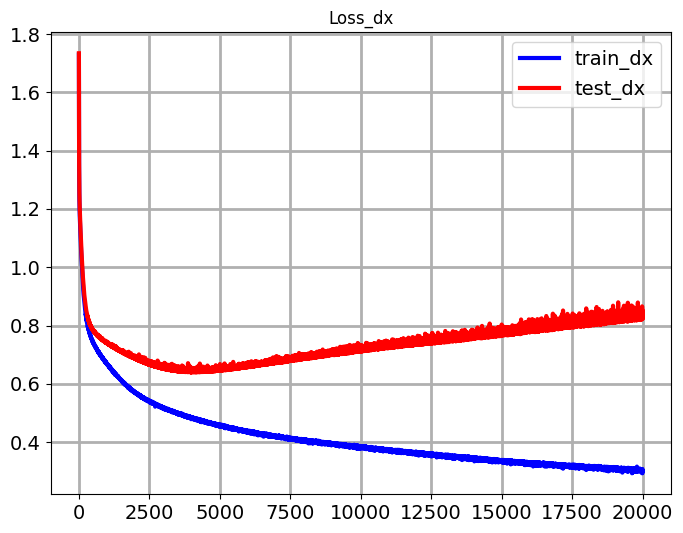

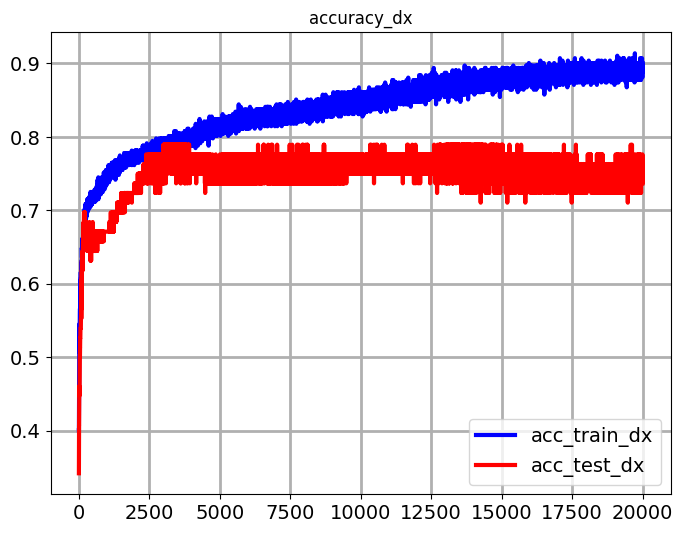

In [40]:
# 学習曲線 (損失関数) 診断モデル
plt.figure(figsize=(8,6))
plt.plot(loss_list_dx,label='train_dx', lw=3, c='b')
plt.plot(loss_list_test_dx,label='test_dx', lw=3, c='r')
plt.title('Loss_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (精度)
plt.figure(figsize=(8,6))
plt.plot(acc_dx,label='acc_train_dx', lw=3, c='b')
plt.plot(acc_test_dx,label='acc_test_dx', lw=3, c='r')
plt.title('accuracy_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()